In [2]:
%load_ext autoreload
%autoreload 2

#pip install antspyx

#Source: https://antspy.readthedocs.io/en/latest/registration.html


#./stitching -i /media/data/NAKO/MRT/3D_GRE_TRA_F/100000_30/ses-20161014/sub-100000_30_ses-20161014_sequ-4_mr.nii.gz /media/data/NAKO/MRT/3D_GRE_TRA_F/100000_30/ses-20161014/sub-100000_30_ses-20161014_sequ-3_mr.nii.gz /media/data/NAKO/MRT/3D_GRE_TRA_F/100000_30/ses-20161014/sub-100000_30_ses-20161014_sequ-2_mr.nii.gz /media/data/NAKO/MRT/3D_GRE_TRA_F/100000_30/ses-20161014/sub-100000_30_ses-20161014_sequ-1_mr.nii.gz -o out2.nii.gz



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import ants #antspyx,
fi = ants.image_read('/media/data/NAKO/MRT/3D_GRE_TRA_F/100000_30/ses-20161014/sub-100000_30_ses-20161014_sequ-4_mr.nii.gz')
mi = ants.image_read('/media/data/NAKO/MRT/3D_GRE_TRA_F/100000_30/ses-20161014/sub-100000_30_ses-20161014_sequ-3_mr.nii.gz')
mytx = ants.registration(fixed=fi, moving=mi, type_of_transform = 'Affine' )
ants.image_write(mytx['warpedmovout'],'/media/data/robert/programme/stitching/stitching/build/stitching/reg3.nii.gz')

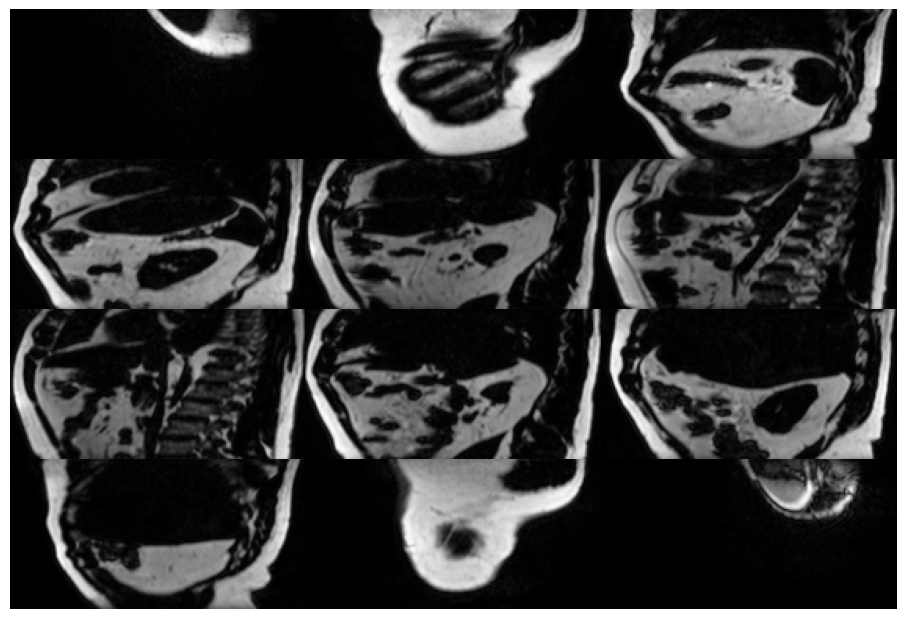

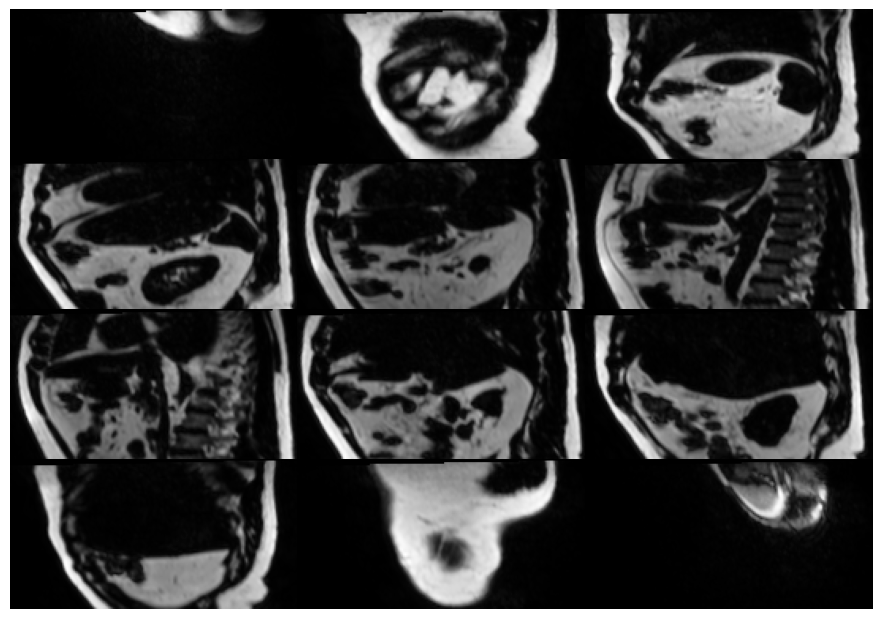

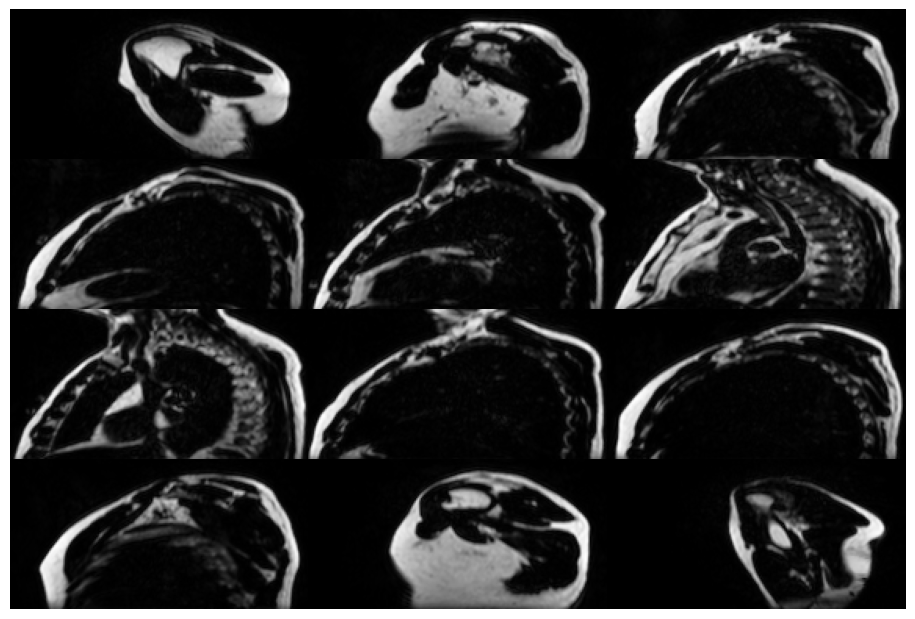

In [27]:
ants.plot(mi,None, crop=True)
ants.plot(mytx['warpedmovout'],None, crop=True)
ants.plot(fi,None, crop=True)


ants
#https://github.com/ANTsX/ANTsPy/blob/master/ants/registration/landmark_transforms.py

In [9]:
mytx

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (60, 60)
 	 Spacing    : (4.322, 4.322)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (60, 60)
 	 Spacing    : (4.322, 4.322)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['/tmp/tmp724c3fa41Warp.nii.gz',
  '/tmp/tmp724c3fa40GenericAffine.mat'],
 'invtransforms': ['/tmp/tmp724c3fa40GenericAffine.mat',
  '/tmp/tmp724c3fa41InverseWarp.nii.gz']}

In [2]:
#auto loaded = itkio::load(files[0]);

import SimpleITK as sitk
file = '/media/data/NAKO/MRT/3D_GRE_TRA_F/100000_30/ses-20161014/sub-100000_30_ses-20161014_sequ-4_mr.nii.gz'
file2 = '/media/data/NAKO/MRT/3D_GRE_TRA_F/100000_30/ses-20161014/sub-100000_30_ses-20161014_sequ-3_mr.nii.gz'
image0 = sitk.Cast(sitk.ReadImage(str(file)), sitk.sitkFloat32)
image1 = sitk.Cast(sitk.ReadImage(str(file2)), sitk.sitkFloat32)

print(image0.GetOrigin()[2],image0.GetOrigin()[2] + image0.GetSize()[2] * image0.GetSpacing()[2])
print(image1.GetOrigin()[2],image1.GetOrigin()[2] + image1.GetSize()[2] * image1.GetSpacing()[2])
#determine physical extent of stitched volume
#auto image0 = subimage(loaded, 0, 0, margin, loaded.sizeX(), loaded.sizeY(), loaded.sizeZ()-2*margin).clone();
#auto image0_min_extent = image0.origin()[2];
#auto image0_max_extent = image0.origin()[2] + image0.sizeZ() * image0.spacing()[2];

-387.5 -99.5
-579.5 -291.5


In [31]:

def cropZ(image: sitk.Image, pad_min_z, pad_max_z, verbose=True) -> sitk.Image:
    # filter = sitk.LessImageFilter()
    # mi = pad_min_z / image.GetSpacing()[2]

    if pad_max_z < 0:
        # ma = image.GetOrigin()[2] + image.GetSize()[2] + pad_max_z * image.GetSpacing()[2]
        # pad_max_z = image.GetSize()[2] + pad_max_z
        pass
    # else:
    # ma = pad_max_z / image.GetSpacing()[2]
    if verbose:
        print("[*] crop ", pad_min_z, abs(pad_max_z), "pixels")
    filter = sitk.CropImageFilter()
    filter.SetLowerBoundaryCropSize([0, 0, pad_min_z])
    filter.SetUpperBoundaryCropSize([0, 0, abs(pad_max_z)])
    return filter.Execute(image)


def affine_registration(fixed_image: sitk.Image, moving_image: sitk.Image, moving_image2) -> sitk.Image:
    initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )

    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(
        sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
    )
    moving_resampled = sitk.Resample(
    moving_image2,
    fixed_image,
    final_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
    )
    return moving_resampled

inter1 = cropZ(image1, image0.GetSize()[-1] - 20, 0)
inter2 = cropZ(image0, 0, image1.GetSize()[-1] - 20)
print(inter1.GetSize(),inter2.GetSize())            
out = affine_registration(inter1,inter2, image0)

#sitk.Show(out)
print(out.GetSize())            

[*] crop  76 0 pixels
[*] crop  0 76 pixels
(320, 260, 20) (320, 260, 20)
(320, 260, 20)


[((20, 1, 260, 320), 0.0, 0.8878748416900635), ((20, 1, 260, 320), 0.0, 0.9915611743927002), ((20, 1, 260, 320), 0.0, 0.9254571199417114)]
tensor(0.) tensor(0.9916)


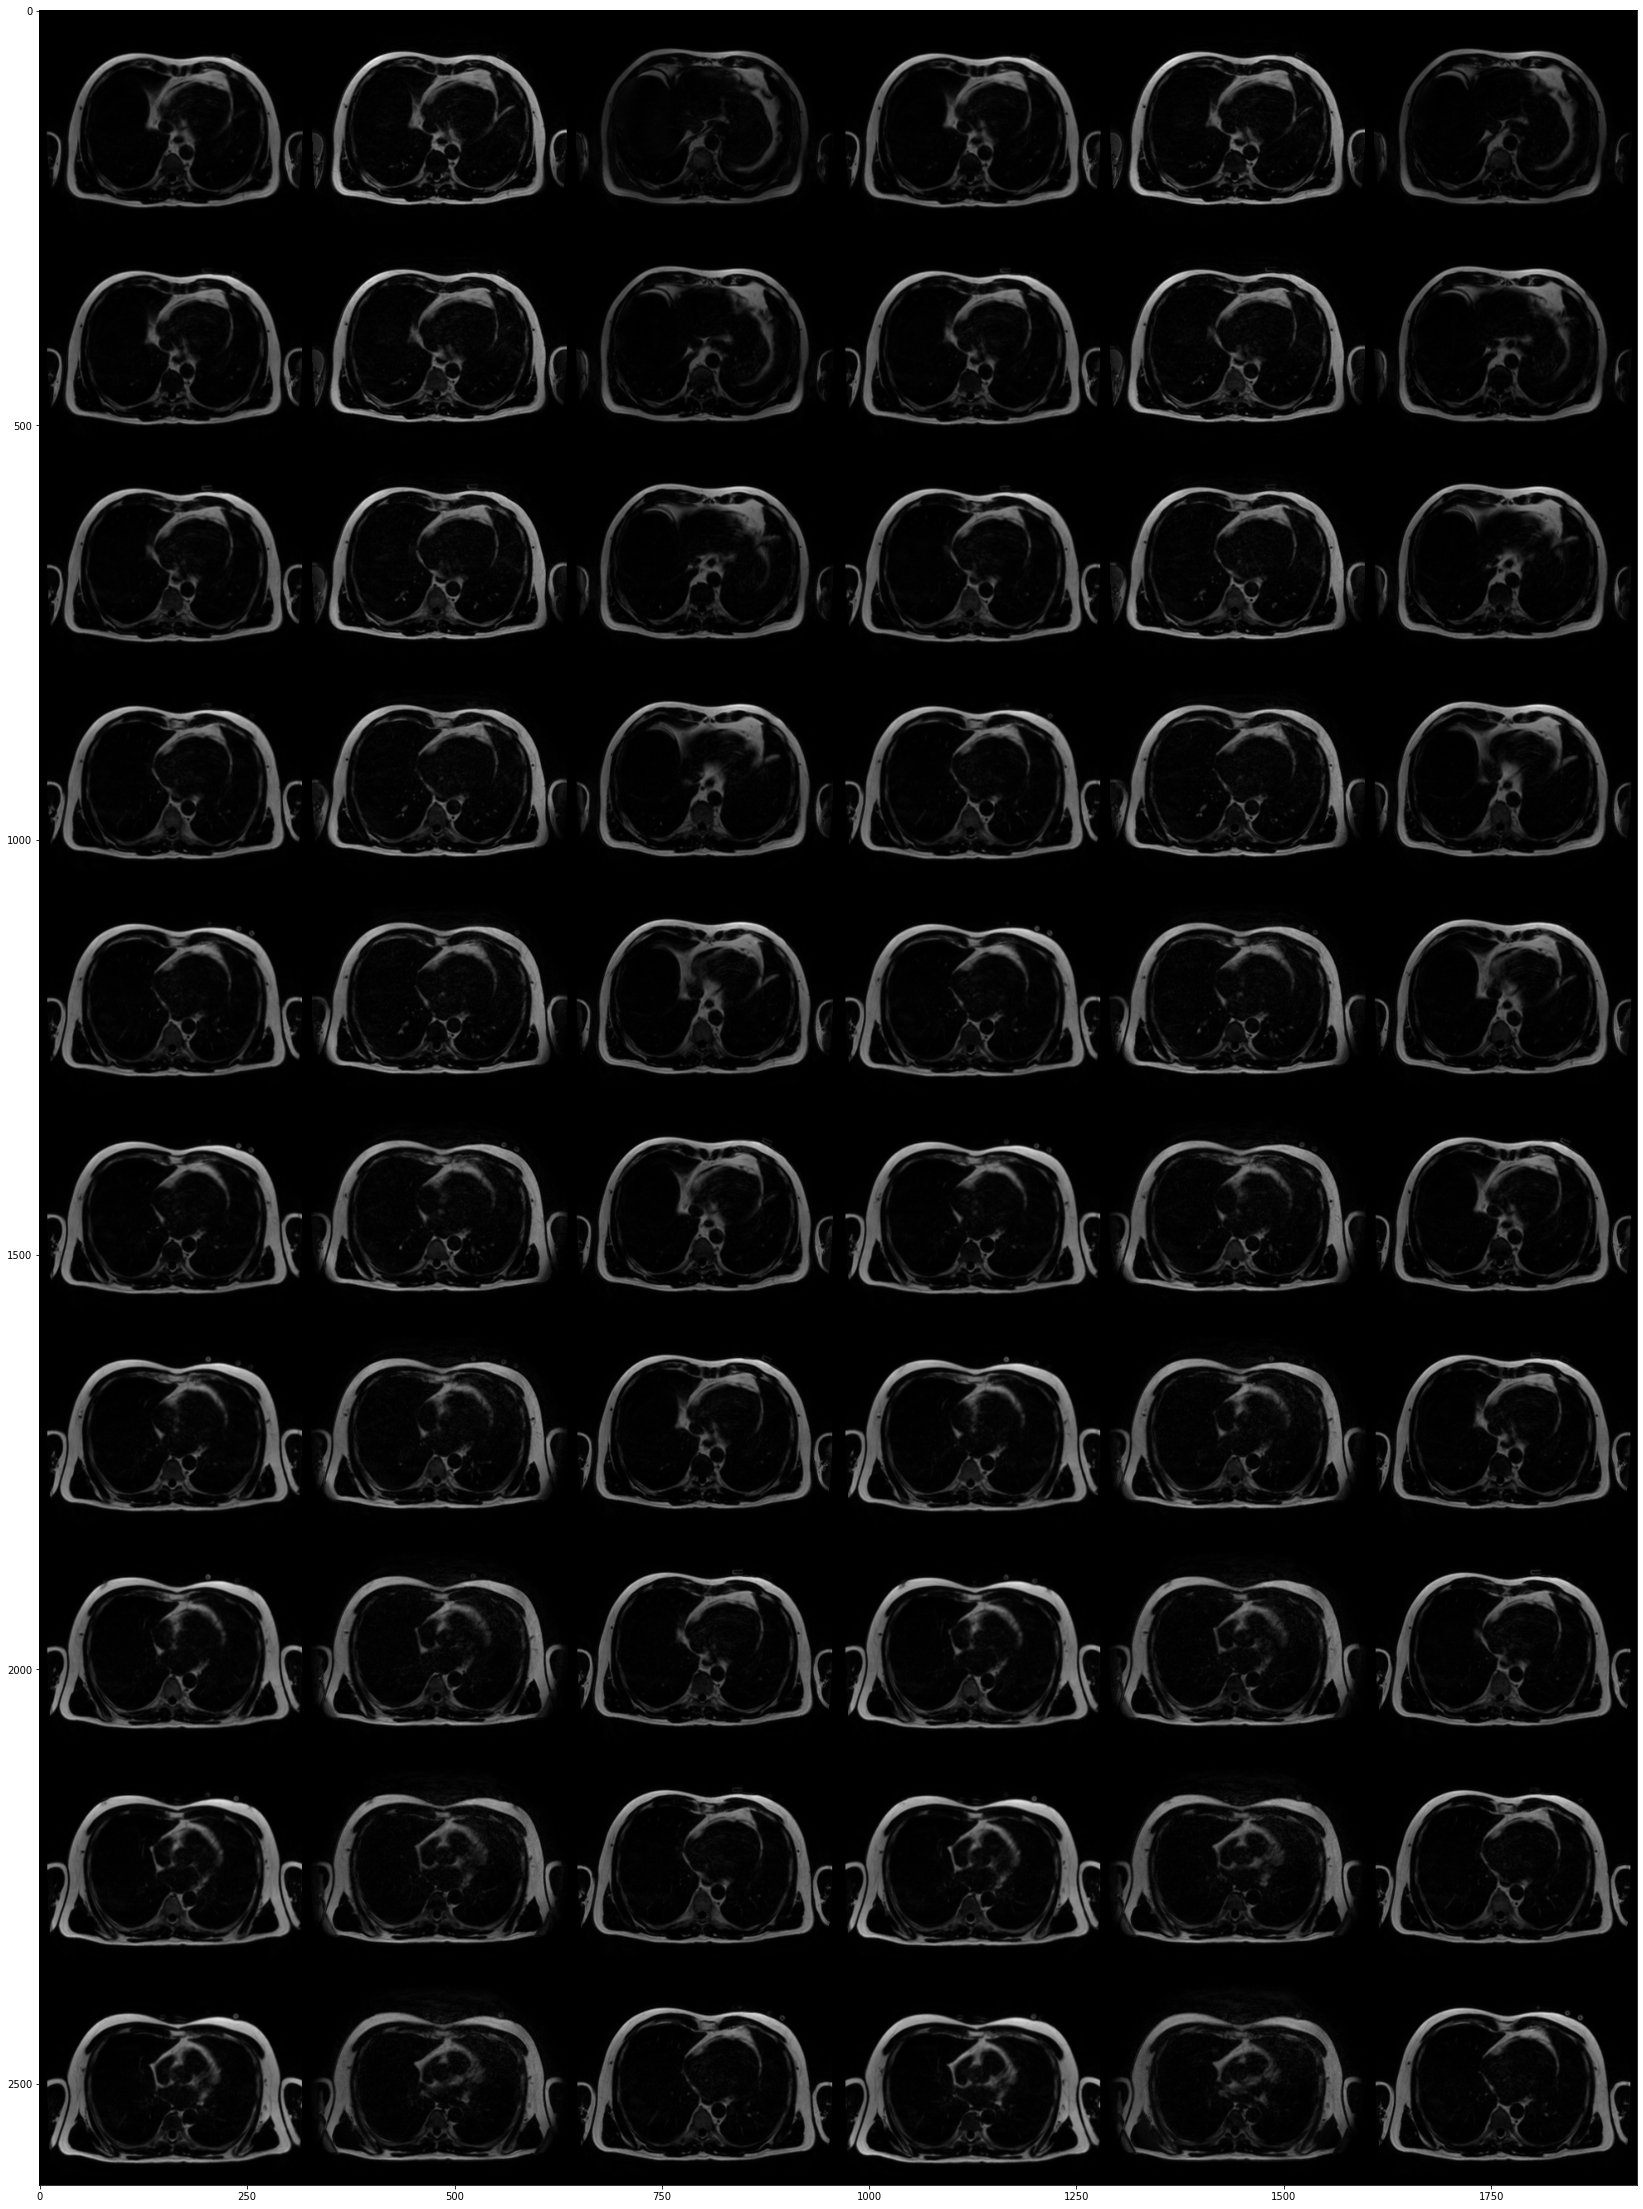

In [32]:
import numpy as np
import torch, torchvision
import matplotlib.pyplot as plt


def show_c_image(arr,nrow=2):
    for i, v in enumerate(arr):
        if isinstance(v,np.ndarray):
            arr[i] = torch.Tensor(v)
        else:
            arr[i] = v.cpu()
        

    print([(tuple(a.shape), a.min().item(),a.max().item()) for a in arr])
    
    
    grid = torchvision.utils.make_grid(torch.cat(arr,dim=-1),nrow=nrow).cpu()
    a = grid.permute(1, 2, 0)
    print(a.min(),a.max())
    plt.figure(figsize = (40,40))
    plt.imshow(a)

show_c_image([np.expand_dims(sitk.GetArrayFromImage(i),1)/711 for i in [out,inter1,inter2]])

In [1]:
#from ants import landmark_transforms
import ants
#ants.landmark_transforms
#https://github.com/ANTsX/ANTsPy/blob/master/ants/registration/landmark_transforms.py

ModuleNotFoundError: No module named 'ants'

In [6]:
!pip install antspyx

Defaulting to user installation because normal site-packages is not writeable
  Using cached antspyx-0.3.3.tar.gz (7.0 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [1179 lines of output]
      /usr/lib/python3/dist-packages/setuptools/dist.py:723: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      running bdist_wheel
      running build
      running build_py
      running build_ext
      Configuring ITK
      No local ITK installation found... Building ITK now...
      Klone nach 'itksource' …
      Bereits auf 'master'
      Ihr Branch ist auf demselben Stand wie 'origin/master'.
      Hinweis: Wechsle zu 'v5.3rc03'.
      
      Sie befinden sich im Zustand eines 'losgelösten HEAD'. Sie können sich
      umschauen, experimentelle Ä